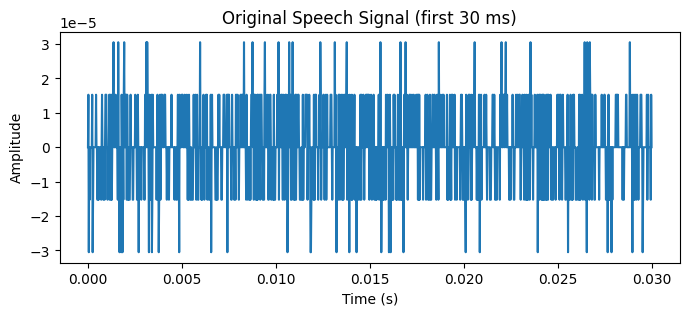

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

# Load speech file (replace with your path)
speech, fs = sf.read("speech.wav")

# If stereo, convert to mono
if speech.ndim > 1:
    speech = np.mean(speech, axis=1)

# Plot time-domain (first 30 ms for clarity)
t = np.linspace(0, len(speech)/fs, len(speech))
plt.figure(figsize=(8,3))
plt.plot(t[:int(0.03*fs)], speech[:int(0.03*fs)])
plt.title("Original Speech Signal (first 30 ms)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


In [3]:
from scipy import signal

def resample_signal(sig, fs_from, fs_to):
    num = int(len(sig) * fs_to / fs_from)
    return signal.resample(sig, num)

# Downsample to 8kHz, 16kHz, and keep 44.1kHz
speech_8k = resample_signal(speech, fs, 8000)
speech_16k = resample_signal(speech, fs, 16000)
speech_44k = resample_signal(speech, fs, 44100)  # reference

print(len(speech_8k), len(speech_16k), len(speech_44k))


146849 293699 809508


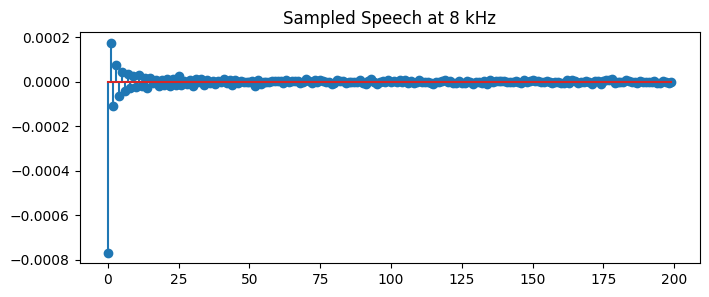

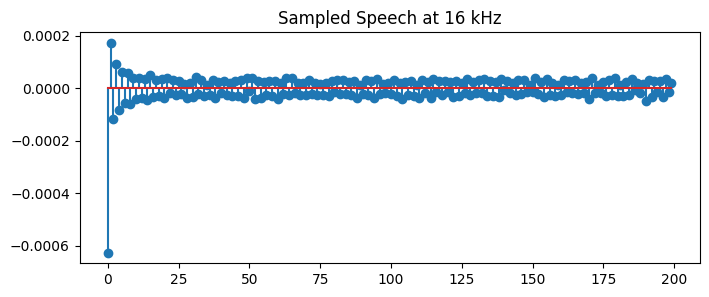

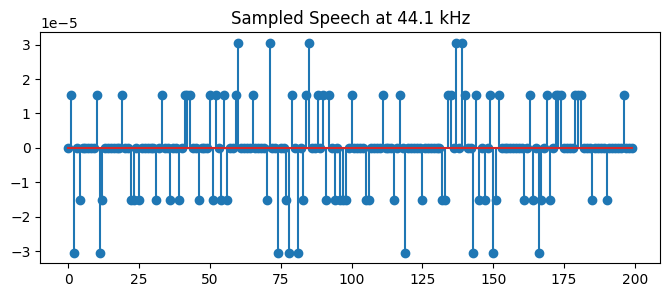

In [4]:
plt.figure(figsize=(8,3))
plt.stem(np.arange(200), speech_8k[:200])
plt.title("Sampled Speech at 8 kHz")
plt.show()

plt.figure(figsize=(8,3))
plt.stem(np.arange(200), speech_16k[:200])
plt.title("Sampled Speech at 16 kHz")
plt.show()

plt.figure(figsize=(8,3))
plt.stem(np.arange(200), speech_44k[:200])
plt.title("Sampled Speech at 44.1 kHz")
plt.show()

In [5]:
def reconstruct(sig, fs_from, fs_to, method='zoh'):
    t_from = np.linspace(0, len(sig)/fs_from, len(sig))
    t_to = np.linspace(0, len(sig)/fs_from, int(len(sig)*fs_to/fs_from))
    if method == 'zoh':  # zero-order hold
        idx = np.minimum((t_to * fs_from).astype(int), len(sig)-1)
        return sig[idx]
    elif method == 'linear':  # linear interpolation
        return np.interp(t_to, t_from, sig)

# Example: reconstruct 8kHz back to 44.1kHz
recon_8k_zoh = reconstruct(speech_8k, 8000, 44100, 'zoh')
recon_8k_lin = reconstruct(speech_8k, 8000, 44100, 'linear')


In [11]:
# ---- Reconstruct back to 44.1 kHz ----
recon_8k_lin = reconstruct(speech_8k, 8000, 44100, 'linear')
recon_16k_lin = reconstruct(speech_16k, 16000, 44100, 'linear')
recon_8k_zoh = reconstruct(speech_8k, 8000, 44100, 'zoh')

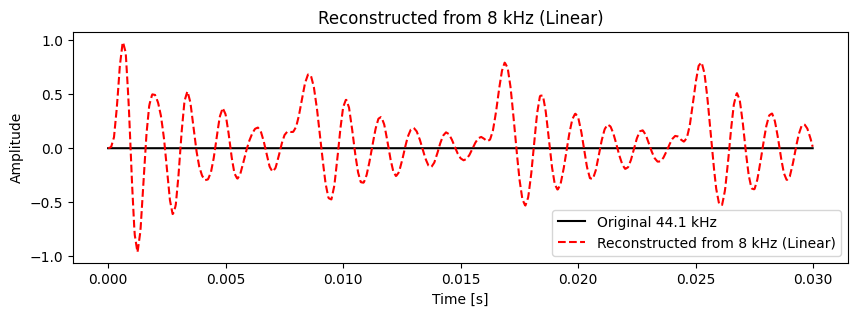

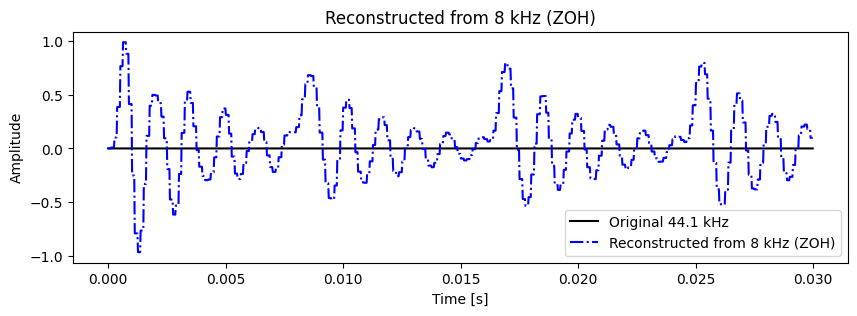

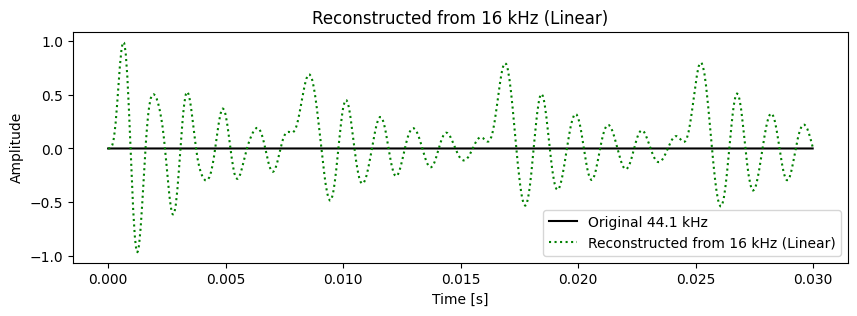

In [13]:
# ---- Time vector for reconstructed signals ----
t_44k = np.linspace(0, len(recon_16k_lin)/fs, len(recon_16k_lin), endpoint=False)

# ---- Define zoom segment (e.g., first 30 ms) ----
zoom_samples = int(0.03 * fs)  # first 30 ms

# ---- Plot reconstructed signals separately ----
# 1. Original vs reconstructed from 8 kHz (Linear)
plt.figure(figsize=(10,3))
plt.plot(t_44k[:zoom_samples], speech_44k[:zoom_samples], 'k', label='Original 44.1 kHz')
plt.plot(t_44k[:zoom_samples], recon_8k_lin[:zoom_samples], 'r--', label='Reconstructed from 8 kHz (Linear)')
plt.title("Reconstructed from 8 kHz (Linear)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# 2. Original vs reconstructed from 8 kHz (ZOH)
plt.figure(figsize=(10,3))
plt.plot(t_44k[:zoom_samples], speech_44k[:zoom_samples], 'k', label='Original 44.1 kHz')
plt.plot(t_44k[:zoom_samples], recon_8k_zoh[:zoom_samples], 'b-.', label='Reconstructed from 8 kHz (ZOH)')
plt.title("Reconstructed from 8 kHz (ZOH)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# 3. Original vs reconstructed from 16 kHz (Linear)
plt.figure(figsize=(10,3))
plt.plot(t_44k[:zoom_samples], speech_44k[:zoom_samples], 'k', label='Original 44.1 kHz')
plt.plot(t_44k[:zoom_samples], recon_16k_lin[:zoom_samples], 'g:', label='Reconstructed from 16 kHz (Linear)')
plt.title("Reconstructed from 16 kHz (Linear)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [7]:
def mse(original, reconstructed):
    L = min(len(original), len(reconstructed))
    return np.mean((original[:L] - reconstructed[:L])**2)

mse_8k_zoh = mse(speech_44k, recon_8k_zoh)
mse_8k_lin = mse(speech_44k, recon_8k_lin)

print("MSE 8kHz ZOH:", mse_8k_zoh)
print("MSE 8kHz Linear:", mse_8k_lin)

MSE 8kHz ZOH: 0.00014018654982817126
MSE 8kHz Linear: 9.621541302086816e-05


(2) Source–Filter Model

In [8]:
# Parameters
fs = 44100
duration = 1.0
t = np.linspace(0, duration, int(fs*duration), endpoint=False)

# Source: Glottal pulse train (voiced)
f0 = 120  # fundamental freq
impulses = np.zeros_like(t)
impulses[::int(fs/f0)] = 1.0

# Glottal shaping with a Hann window
g = np.hanning(int(0.002*fs))
source = np.convolve(impulses, g, mode='same')

# Filter: Vocal tract formants
from scipy.signal import lfilter

def resonator(fs, f, bw):
    r = np.exp(-np.pi*bw/fs)
    theta = 2*np.pi*f/fs
    a = [1, -2*r*np.cos(theta), r**2]
    b = [1-r]
    return b, a

formants = [(700,80), (1200,100), (2600,150)]
speech_model = source.copy()
for f_form, bw in formants:
    b, a = resonator(fs, f_form, bw)
    b_full = [b[0], 0, 0]  # expand numerator
    speech_model = lfilter(b_full, a, speech_model)

speech_model = speech_model / np.max(np.abs(speech_model))  # normalize


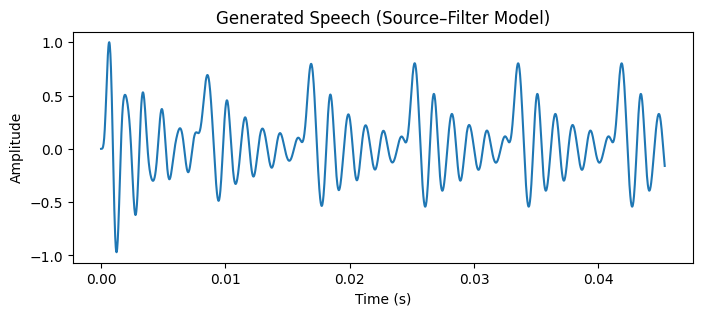

In [9]:
plt.figure(figsize=(8,3))
plt.plot(t[:2000], speech_model[:2000])
plt.title("Generated Speech (Source–Filter Model)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


In [10]:
speech_8k = resample_signal(speech_model, fs, 8000)
speech_16k = resample_signal(speech_model, fs, 16000)
speech_44k = resample_signal(speech_model, fs, 44100)


In [11]:
recon_16k_lin = reconstruct(speech_16k, 16000, 44100, 'linear')
recon_8k_lin = reconstruct(speech_8k, 8000, 44100, 'linear')

In [12]:
print("MSE 16kHz Linear:", mse(speech_44k, recon_16k_lin))
print("MSE 8kHz Linear:", mse(speech_44k, recon_8k_lin))

MSE 16kHz Linear: 0.0006281703125421909
MSE 8kHz Linear: 0.00406421627701093


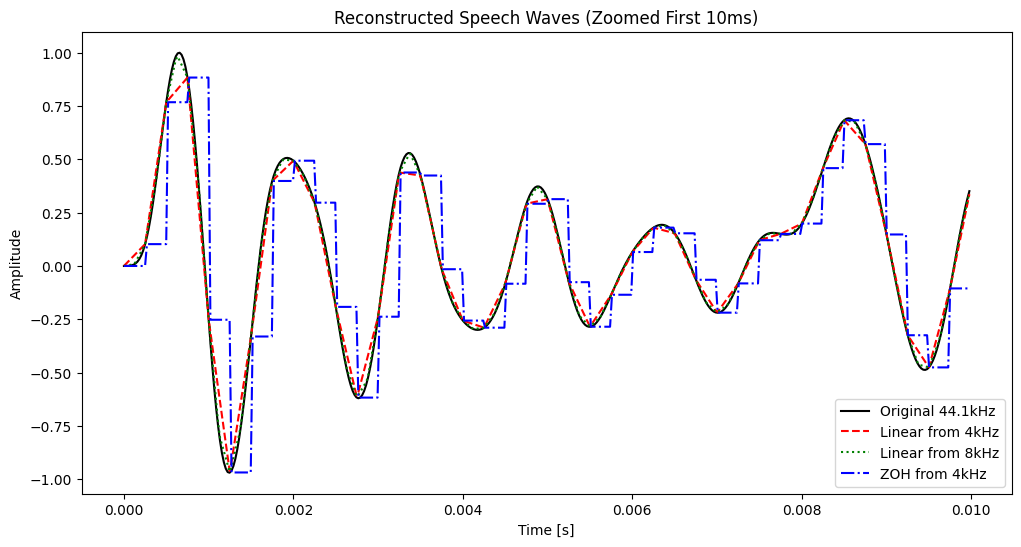

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

# ---- Parameters ----
fs = 44100
duration = 0.1  # 100 ms
t = np.linspace(0, duration, int(fs*duration), endpoint=False)

# ---- Source: Glottal pulse train ----
f0 = 120  # Hz
impulses = np.zeros_like(t)
impulses[::int(fs/f0)] = 1.0
g = np.hanning(int(0.002*fs))
source = np.convolve(impulses, g, mode='same')

# ---- Vocal tract formants ----
def resonator(fs, f, bw):
    r = np.exp(-np.pi*bw/fs)
    theta = 2*np.pi*f/fs
    a = [1, -2*r*np.cos(theta), r**2]
    b = [1-r]
    return b, a

formants = [(700,80), (1200,100), (2600,150)]
speech_model = source.copy()
for f_form, bw in formants:
    b, a = resonator(fs, f_form, bw)
    b_full = [b[0], 0, 0]
    speech_model = lfilter(b_full, a, speech_model)

speech_model /= np.max(np.abs(speech_model))

# ---- Resample & Reconstruct ----
def resample_signal(sig, fs_from, fs_to):
    N_to = int(round(len(sig) * fs_to / fs_from))
    t_from = np.linspace(0, len(sig)/fs_from, len(sig), endpoint=False)
    t_to = np.linspace(0, len(sig)/fs_from, N_to, endpoint=False)
    return np.interp(t_to, t_from, sig)

def reconstruct(sig, fs_from, fs_to, method='linear'):
    N_to = int(round(len(sig) * fs_to / fs_from))
    t_from = np.linspace(0, len(sig)/fs_from, len(sig), endpoint=False)
    t_to = np.linspace(0, len(sig)/fs_from, N_to, endpoint=False)
    if method == 'zoh':
        idx = np.minimum((t_to * fs_from).astype(int), len(sig)-1)
        return sig[idx]
    else:
        return np.interp(t_to, t_from, sig)

speech_4k = resample_signal(speech_model, fs, 4000)
speech_8k = resample_signal(speech_model, fs, 8000)

recon_4k_lin = reconstruct(speech_4k, 4000, fs, 'linear')
recon_8k_lin = reconstruct(speech_8k, 8000, fs, 'linear')
recon_4k_zoh = reconstruct(speech_4k, 4000, fs, 'zoh')

# ---- Plot only first 10 ms to highlight differences ----
zoom_samples = int(0.01 * fs)

plt.figure(figsize=(12,6))
plt.plot(t[:zoom_samples], speech_model[:zoom_samples], 'k', label='Original 44.1kHz')
plt.plot(t[:zoom_samples], recon_4k_lin[:zoom_samples], 'r--', label='Linear from 4kHz')
plt.plot(t[:zoom_samples], recon_8k_lin[:zoom_samples], 'g:', label='Linear from 8kHz')
plt.plot(t[:zoom_samples], recon_4k_zoh[:zoom_samples], 'b-.', label='ZOH from 4kHz')

plt.title("Reconstructed Speech Waves (Zoomed First 10ms)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()
